In [1]:
# default_exp analyses

# The Lag-Contiguity Effect
The lag-contiguity effect illustrates how episodic associations are graded, exhibiting power-function decay with increasing lag. 
Recall of an item has a tendency to evoke not only adjacent list items, but other nearby items as well. 
In addition, episodic associations appear to be asymmetrical, favoring retrieval of items in the forward order.

To measure the lag-contiguity effect, we often produce lag-CRP curves. 
"Lag-CRP" measures the conditional probability of recalling an item as a function of its adjacency (**lag**) in the study list to the the last recalled item. 
To find this in our free recall data, for every recall a participant made in a dataset, we measure how adjacent the recalled item was from the *next* item the participant recalled -- its serial lag. 
For example, if a subject recalls the third item presented in a list and then the fourth, the lag of the next item recalled is +1. 
If a subject instead recalls the first item after recalling the third item, the measured lag is -2. 
We also track across recalls which lag lags were possible based on which items were not already retrieved. 
Once we've tallied up all actual and possible lag lags across a dataset, we plot for each lag the ratio of actual lags divided by position lags to visualize the conditional probability of each lag lag.

## Data Preparation
For our demonstrations, we'll lean on the MurdockOkada1970 dataset. 
As a reminder, in this dataset each of 72 undergraduates was given 20 test lists with 20-word lists visually presented at either 60 or 120 words/min.

In [2]:
from compmemlearn.datasets import prepare_murdock1970_data

trials, events, list_length = prepare_murdock1970_data('../../data/mo1970.txt')
events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


## Analysis

### DataFrame
We can usually rely on the `psifr` library to generate `pandas` DataFrames containing lag-CRP information. 

In [3]:
from psifr import fr

crp = fr.lag_crp(events)
crp

prob  actual  possible
subject lag                            
1       -19  0.166667       2        12
        -18  0.083333       2        24
        -17  0.025641       1        39
        -16  0.019608       1        51
        -15  0.030303       2        66
...               ...     ...       ...
72       15  0.000000       0        12
         16  0.000000       0         3
         17  0.000000       0         4
         18  0.000000       0         1
         19       NaN       0         0

[2808 rows x 3 columns]

### Fast Array Generation
`DataFrame`s contain granular subject-by-subject information and are easier to plot using the `seaborn` library. 
But sometimes we don't need this granular information and mainly want to perform our analysis as quickly as possible -- perhaps to help with model fitting or analysis. 
In that case, representing results with `numpy` arrays and performing just-in-time compilation of our function using `numba` might be preferred. 
We include `analyses.fast_crp` in our library for that purpose here.

In [4]:
# export

from numba import njit
import numpy as np

@njit(fastmath=True, nogil=True)
def fast_crp(trials, item_count):
    
    lag_range = item_count - 1
    total_actual_lags = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    terminus = np.sum(trials != 0, axis=1) - 1
    
    # compute actual serial lag b/t recalls
    actual_lags = trials[:, 1:] - trials[:, :-1]
    actual_lags += lag_range
    
    # tabulate bin totals for actual and possible lags
    for i in range(len(trials)):
        possible_items = np.arange(item_count) + 1
        previous_item = 0
        
        for recall_index in range(terminus[i]):
            
            # track possible and actual lags
            if recall_index > 0:
                total_actual_lags[actual_lags[i, recall_index-1]] += 1
                
                # exploit equivalence b/t item index and study position to track possible lags
                possible_lags = possible_items - previous_item 
                possible_lags += lag_range
                total_possible_lags[possible_lags] += 1
                
            # update pool of possible items to exclude recalled item
            previous_item = trials[i, recall_index]
            possible_items = possible_items[possible_items != previous_item]
    
    # small correction to avoid nans
    total_possible_lags[total_actual_lags==0] += 1
    
    return total_actual_lags/total_possible_lags

In [5]:
fast_crp(trials, list_length)

array([0.11194833, 0.03286908, 0.02979224, 0.01779829, 0.01801004,
       0.01967213, 0.02168301, 0.02174988, 0.01745576, 0.02244564,
       0.01840073, 0.02068045, 0.02734631, 0.03158573, 0.03094984,
       0.03477888, 0.03878924, 0.06394491, 0.12011662, 0.        ,
       0.48289691, 0.13780099, 0.07602765, 0.0509468 , 0.04898829,
       0.04222766, 0.03398058, 0.03364632, 0.03133159, 0.03981043,
       0.02836134, 0.03694875, 0.02291105, 0.02134146, 0.03386809,
       0.03296703, 0.04388715, 0.05803571, 0.02158273])

We can compare the runtimes of `compmemlearn`'s `analyses.fast_crp` and `psifr`'s `fr.lag_crp` using the `%%timeit` Jupyter magic:

In [6]:
%%timeit
fast_crp(trials, 20)

2.96 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%timeit
fr.lag_crp(events)

429 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Our fast implementation is more than 100 times faster!

## Plotting
`psifr`'s plotting library creates a separate figure for each plot, when sometimes we want to to include multiple plots in one figure, so we define our own.

In [8]:
# export
import seaborn as sns
from psifr import fr

def plot_lag_crp(data, max_lag=5, **facet_kws):
    
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'
    
    crp_data = fr.lag_crp(data)
    
    sns.lineplot(
        data=crp_data.query(filt_neg), 
        x='lag', y='prob', **facet_kws)
    sns.lineplot(
        data=crp_data.query(filt_pos), 
        x='lag', y='prob', **facet_kws)

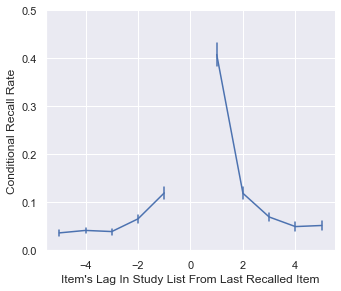

In [9]:
sns.set_theme(style="darkgrid")

g = sns.FacetGrid(dropna=False, data=events, height=4, aspect=1.2)
g.map_dataframe(plot_lag_crp, err_style='bars')
g.set(ylim=(0, .5))

g.set_xlabels('Item\'s Lag In Study List From Last Recalled Item')
g.set_ylabels('Conditional Recall Rate');